 # Курсовая работа
 ## на тему "Датасеты"

1) Выбор своего датасета (условие — выполнено в виде интерактивной презентации в юпитере)

Нужно попытаться визуализировать экземпляр данных

2) найти публикацию\статью про датасет, внедрить ссылку и кратко описать в презентации (+ какие популярные модели используются)

3) Пример данных с разметкой + пример кода для загрузки тестового набора

4) Пример применения готовой модели на этих данных

!) Обязательное использование Markdown + LaTeX

!) Обязательное использование Plotly

!) Обязательное использование готового кода с алгоритмом относительно датасета

!) Обязательно воспользоваться доплнительно TensorBoard или аналогом

*) (realesrgan, pifuhd) Препроцессинг другой моделью (+ описать)

Титульник надо напечатать + ссылка на ноутбук

## 1 + 2) Выбор Датасета, Публикация\Статья про датасет, ссылка, краткое описание
Мой выбор пал на датасет Reddit. Ссылка: https://paperswithcode.com/dataset/reddit

Данный датасет представляет собой датасет графов, состоящий из постов сайта Reddit, сделанного в месяце сентября 2014 года. Данные разделены на сообщества или "Суб-Реддиты", каждому из которых принадлежит своё сообщение. Сообщения были взяты из 50 крупнейших сообществ и были построены в графике "Публикация-к-публикации", соединяющие посты одного пользователя. В общей сложности датасет состоит из 232 965 постов в средней степенью 492. Первые 20 дней используются для обучения, остальные дни - для тестирования (из них 30% используются для валидации). Для моделей подготовлены 300-мерные векторы слов GloVe CommonCrawl.

## 3) Пример данных с разметкой + пример кода для загрузки тестового набора

In [1]:
import os
from copy import deepcopy
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data
from torch_geometric.loader.neighbor_sampler import EdgeIndex
from torch_geometric.utils import to_networkx
from torch_geometric.utils import subgraph
from tqdm import tqdm

In [2]:
from torch_geometric.datasets import Reddit
from torch_geometric.loader import NeighborSampler

In [3]:
path = os.path.join("..", "tmp", "data", "Reddit")
show_dataset = Reddit(path)
show_data = show_dataset[0]

# Print information about the dataset
print(f'Number of graphs: {len(show_dataset)}')
print(f'Number of nodes: {show_dataset[0].x.shape[0]}')
print(f'Number of features: {show_dataset.num_features}')
print(f'Number of classes: {show_dataset.num_classes}')
print(f'Has isolated nodes: {show_dataset[0].has_isolated_nodes()}')

Number of graphs: 1
Number of nodes: 232965
Number of features: 602
Number of classes: 41
Has isolated nodes: False


<BarContainer object of 5401 artists>

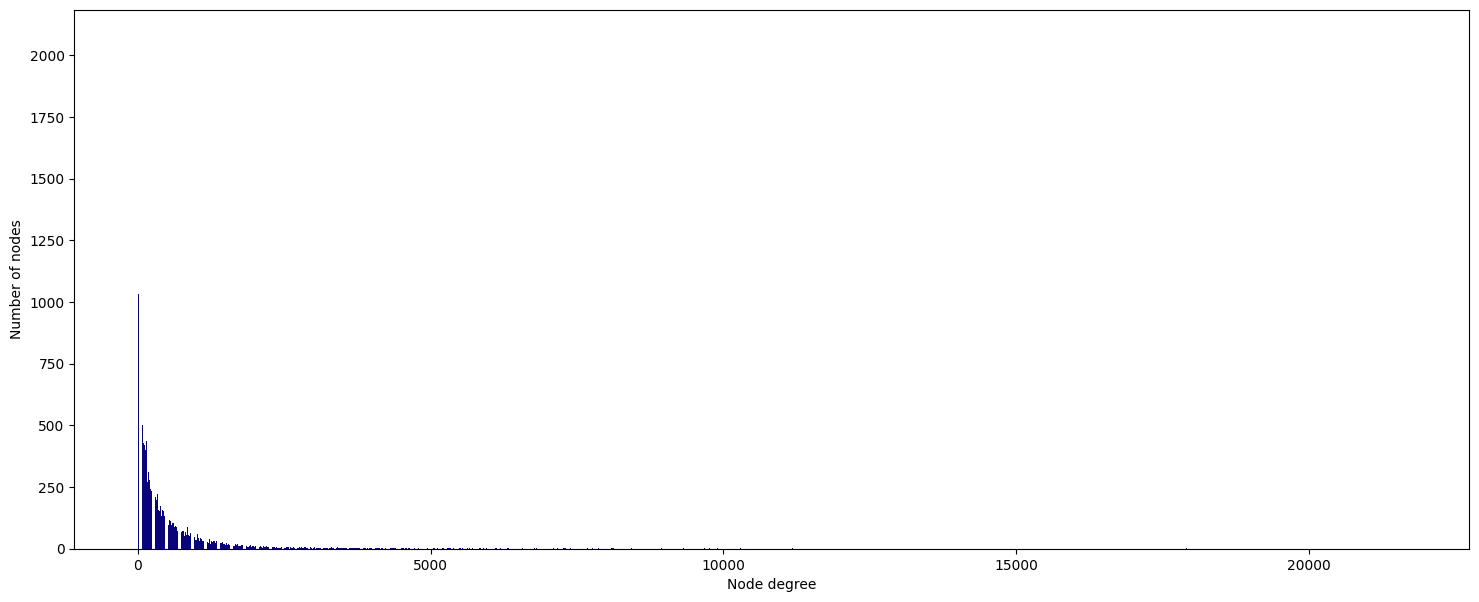

In [4]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(show_data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

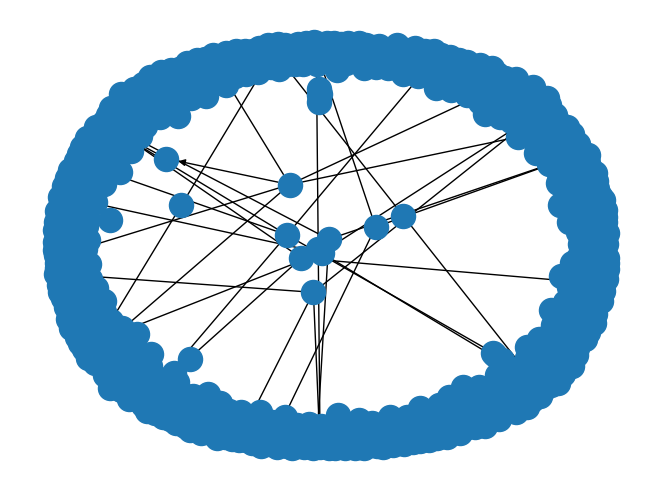

In [5]:
plot_data = show_data
plot_data.x.resize_(1000,602)
plot_data.edge_index.resize_(2,10000)
plot_data.y.resize_(1000)
plot_data.train_mask.resize_(1000)
plot_data.val_mask.resize_(1000)
plot_data.test_mask.resize_(1000)
#print(plot_data)

g = to_networkx(plot_data)
nx.draw(g)

## 4) Пример применения готовой модели на этих данных + (*) Препроцессинг

Датасет Reddit был впервые представлен на демонстрации модели **GraphSAGE**, техники обучения представлению, подходящую для динамических графов. GraphSAGE способен прогнозировать внедрение нового узла, не требуя процедуры повторного обучения (в отличие от DeepWalk). Для этого GraphSAGE учит *агрегаторные функции*, что позволяет вызвать вложение нового узла, учитывая его особенности и окрестности. Это называется *индуктивное обучение*.

Мы можем разделить GraphSAGE на три основные части: построение контекста, агрегация информации, а также функция потери. Ниже мы опишем каждую часть отдельно.

# Построение контекста

Как и в Word2vec и DeepWalk, GraphSAGE также имеет контекстное предположение о сходстве.

GraphSAGE предполагает, что узлы, которые находятся в одной и той же окрестности, должны иметь похожие вложения.

Подобно DeepWalk, определение контекста является параметрическим. Алгоритм имеет параметр **К** который контролирует глубину окрестности. Если **К** == 1, только соседние узлы принимаются как похожие. Если **К** равно 2, узлы на расстоянии 2 также видны в той же окрестности.

Обратите внимание, что при **К** = 2 означает, что узлы на расстоянии 4 могут влиять на вложения друг друга через узел посередине. Следовательно, увеличение длины обхода может привести к нежелательному обмену информацией между узлами. слишком большой **К** может даже вызвать одинаковое вложение для всех узлов!

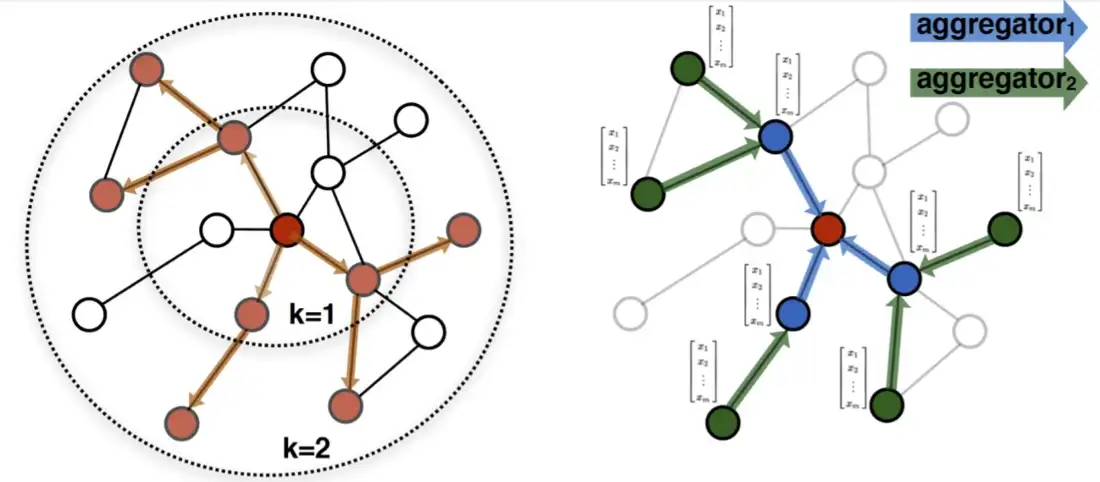

# Агрегация информации

Определив окрестности, нам нужна процедура обмена информацией между соседями. *Агрегирующие функции* или *агрегаторы* принимают окрестность в качестве входных данных и объединяют вложение каждого соседа с весами, чтобы создать вложение окрестности. Другими словами, они собирают информацию из окрестности узла. Вес агрегатора определяется или фиксируется в зависимости от функции.

Чтобы изучить вложения с помощью агрегаторов, мы сначала инициализируем вложения всех узлов в особенности узлов. В свою очередь, для каждой глубины соседства до **K**,мы создаем вложение соседства с функцией-агрегатором для каждого узла и объединяем его с существующим встраиванием узла. Мы передаем объединенный вектор через слой нейронной сети, чтобы обновить встраивание узла. Когда каждый узел обрабатывается, мы нормализуем вложения, чтобы иметь единичную норму. Псевдокод можно найти ниже.

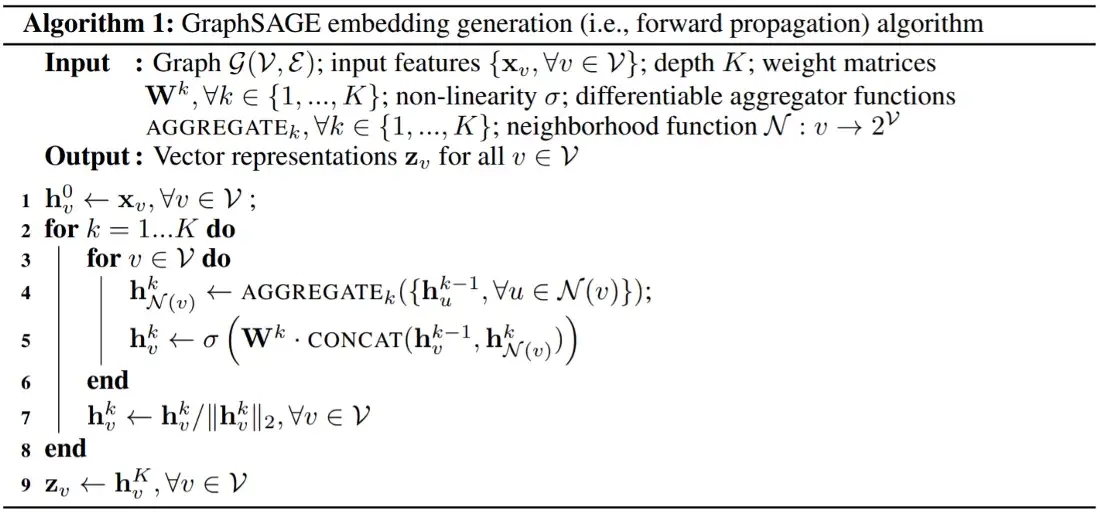

Преимущество изучения агрегаторных функций для генерации вложений узлов вместо изучения самих вложений заключается в индуктивности.

Когда весы агрегатора изучены, встраивание невидимого узла может быть сгенерировано из его особенностей и окрестности.

В результате агрегаторы устраняют необходимость повторного обучения, когда на графе вводятся новые узлы. Обратите внимание, что это довольно часто встречается в социальных сетях, сети, сетях цитирования и так далее.

# Функция потери

До сих пор мы описывали процедуру генерации вложений узлов. Тем не менее, чтобы узнать вес агрегаторов и вложений, нам нужна дифференцируемая функция потерь. Основываясь на нашей интуиции, мы хотим, чтобы соседние узлы имели одинаковые вложения, а независимые узлы имели удаленные векторы вложения. Функция ниже удовлетворяет этим двум условиям с двумя членами.

$$Jg(z_u) = -log(\sigma(z_u*z_v)) - Q*\mathbb{E}_{v_n \sim P_n(v)} *log(\sigma(-z_u*z_{v_n}))$$

Здесь **u** а также **v** - два соседа и потери рассчитаны для **u**, Первый термин способствует максимизации подобия вложений **u** а также **v** как мы и хотели. Во втором члене у нас есть переменная **Q**,это количество отрицательных образцов и **vₙ** является отрицательной выборкой, взятой из распределения отрицательной выборки. Отрицательная выборка в этом контексте означает не соседний узел. Этот термин пытается отделить вложения этих двух узлов. И, наконец,σиспользуется для обозначения сигмовидной функции как обычно.

Обратите внимание, что это неконтролируемая функция потерь, которую можно свести к минимуму без меток. Чтобы использовать GraphSAGE в контролируемом контексте, у нас есть два варианта. Мы можем либо изучить встраивание узлов в качестве первого шага, а затем узнать соответствие между вложениями и метками, либо мы можем добавить контролируемый термин потери в функцию потерь и принять процедуру сквозного обучения. Эта гибкость очень ценна.

# Вывод

GraphSAGE - это алгоритм обучения с индуктивным представлением, который особенно полезен для графиков, которые растут со временем. С помощью GraphSAGE гораздо быстрее создавать вложения для новых узлов по сравнению с методами преобразования. Кроме того, GraphSAGE не ставит под угрозу производительность для скорости. Он был протестирован на трех различных наборах данных, которые влекут за собой классификацию узлов, кластеризацию узлов и обобщение графов и превосходят существующие решения.

В настоящее время есть расширение GraphSAGE для гетерогенных сетей, а также новые индуктивные подходы. Тем не менее, GraphSAGE принял новаторскую и влиятельную роль в обучении индуктивного представления графов.

In [6]:
from torch_geometric.nn import SAGEConv

In [7]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int) -> None:
        super().__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x: torch.Tensor, adjs: List[EdgeIndex]) -> torch.Tensor:
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[: size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1)

    def inference(self, x_all: torch.Tensor, subgraph_loader: NeighborSampler) -> torch.Tensor:
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description("Evaluating")

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[: size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all

In [8]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        x: torch.Tensor,
        y: torch.Tensor,
        train_mask: torch.Tensor,
        val_mask: torch.Tensor,
        test_mask: torch.Tensor,
        optimizer: torch.optim.Optimizer,
        sizes: List[int] = [25, 10],
        batch_size: int = 512,
        num_workers: int = 2,
    ) -> None:
        self.model = model
        self.data = data
        self.x = x
        self.y = y
        self.train_mask = train_mask
        self.val_mask = val_mask
        self.test_mask = test_mask
        self.optimizer = optimizer
        self.train_loader = NeighborSampler(
            data.edge_index,
            node_idx=data.train_mask,
            sizes=sizes,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
        )
        self.subgraph_loader = NeighborSampler(
            data.edge_index, node_idx=None, sizes=[-1], batch_size=batch_size, shuffle=False, num_workers=num_workers
        )

    def training_epoch(self, epoch: int) -> float:
        self.model.train()
        pbar = tqdm(total=int(self.train_mask.sum()))
        pbar.set_description(f"Epoch {epoch:02d}")
        total_loss = 0
        for batch_size, n_id, adjs in self.train_loader:
            # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
            adjs = [adj.to(device) for adj in adjs]
            self.optimizer.zero_grad()
            out = self.model(self.x[n_id], adjs)
            loss = F.nll_loss(out, self.y[n_id[:batch_size]])
            loss.backward()
            self.optimizer.step()
            total_loss += float(loss)
            pbar.update(batch_size)

        pbar.close()
        loss = total_loss / len(self.train_loader)
        return loss

    @torch.no_grad()
    def evaluate(self) -> List[float]:
        self.model.eval()

        out = self.model.inference(self.x, self.subgraph_loader)
        y_true = self.y.cpu().unsqueeze(-1)
        y_pred = out.argmax(dim=-1, keepdim=True)

        results = []
        for mask in [self.train_mask, self.val_mask, self.test_mask]:
            results += [int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]

        return results

    def fit(self, num_epochs: int = 10) -> None:
        for epoch in range(1, num_epochs + 1):
            loss = self.training_epoch(epoch)
            
            writer = SummaryWriter('runs/MAI_114M_AI_CP_test')
            writer.add_scalar('Loss', loss, epoch)
            
            print(f"Epoch {epoch:02d}, Loss: {loss:.4f}")
            train_acc, val_acc, test_acc = self.evaluate()
            print(f"Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

In [9]:
path = os.path.join("..", "tmp", "data", "Reddit")
dataset = Reddit(path)
data = dataset[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SAGE(dataset.num_features, 256, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = Trainer(
    model=model.to(device),
    x=data.x.to(device),
    y=data.y.squeeze().to(device),
    train_mask=data.train_mask,
    val_mask=data.val_mask,
    test_mask=data.test_mask,
    optimizer=optimizer,
)
trainer.fit(num_epochs=5)

torch.cuda.empty_cache()

Epoch 01: 100%|██████████████████████████████████████████████████████████████| 153431/153431 [00:36<00:00, 4152.47it/s]


Epoch 01, Loss: 0.6660


Evaluating: 100%|███████████████████████████████████████████████████████████| 465930/465930 [00:36<00:00, 12682.76it/s]


Train: 0.9415, Val: 0.9430, Test: 0.9416


Epoch 02: 100%|██████████████████████████████████████████████████████████████| 153431/153431 [00:33<00:00, 4522.44it/s]


Epoch 02, Loss: 0.8809


Evaluating: 100%|███████████████████████████████████████████████████████████| 465930/465930 [00:41<00:00, 11323.21it/s]


Train: 0.9460, Val: 0.9454, Test: 0.9421


Epoch 03: 100%|██████████████████████████████████████████████████████████████| 153431/153431 [00:33<00:00, 4610.20it/s]


Epoch 03, Loss: 0.9731


Evaluating: 100%|███████████████████████████████████████████████████████████| 465930/465930 [00:38<00:00, 12128.05it/s]


Train: 0.9486, Val: 0.9444, Test: 0.9459


Epoch 04: 100%|██████████████████████████████████████████████████████████████| 153431/153431 [00:33<00:00, 4540.70it/s]


Epoch 04, Loss: 0.9228


Evaluating: 100%|███████████████████████████████████████████████████████████| 465930/465930 [00:40<00:00, 11408.87it/s]


Train: 0.9484, Val: 0.9425, Test: 0.9431


Epoch 05: 100%|██████████████████████████████████████████████████████████████| 153431/153431 [00:33<00:00, 4617.34it/s]


Epoch 05, Loss: 1.0268


Evaluating: 100%|███████████████████████████████████████████████████████████| 465930/465930 [00:39<00:00, 11653.77it/s]

Train: 0.9529, Val: 0.9461, Test: 0.9474


In [12]:
#%tensorboard --logdir runs/MAI_114M_AI_CP_test

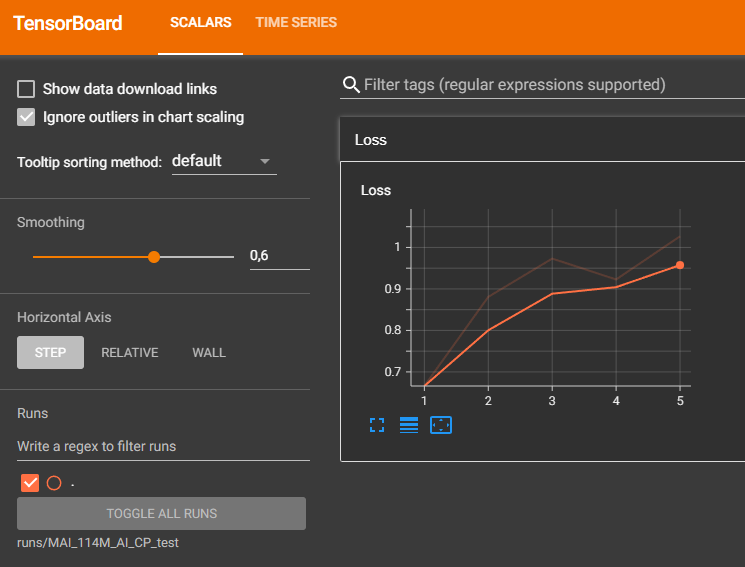